In [2]:
# imports
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics


In [98]:
# globales
df = pd.read_csv("../data/data_limpia.csv", encoding="ISO-8859-1", low_memory=False)
dfPredicReal = pd.read_csv("../data/data_predic.csv", encoding="ISO-8859-1", low_memory=False)
print(f'\n DF limpio:')
print(df.info())
#scaling_factor = 1000 



 DF limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433907 entries, 0 to 433906
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    433907 non-null  object 
 1   StockCode    433907 non-null  object 
 2   Description  433907 non-null  object 
 3   Quantity     433907 non-null  int64  
 4   InvoiceDate  433907 non-null  object 
 5   UnitPrice    433907 non-null  float64
 6   CustomerID   433907 non-null  float64
 7   Country      433907 non-null  object 
 8   Total        433907 non-null  float64
 9   Year         433907 non-null  int64  
 10  Month        433907 non-null  int64  
 11  Day          433907 non-null  int64  
 12  DayOfWeek    433907 non-null  int64  
 13  Season       433907 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 46.3+ MB
None


In [100]:
# paso a datetime por si acaso
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# se necesitan dos columnas 'ds' e 'y', ds son las fechas, 'y' los valores que se quiere predecir
#dfPreparacion = df.set_index('InvoiceDate').resample('h')['Total'].sum().reset_index()

dfPreparacion= df.groupby(df['InvoiceDate'].dt.day)['Total'].sum().reset_index()

# añadimos todos los domingos al df
dfPreparacion['InvoiceDate'] = pd.to_datetime(dfPreparacion['InvoiceDate'])
dfPreparacion = dfPreparacion.set_index('InvoiceDate').resample('D').mean().fillna(0)
dfPreparacion = dfPreparacion.reset_index()

dfPreparacion.columns = ['ds', 'y']
dfPreparacion['ds'] = pd.to_datetime(dfPreparacion['ds'])
#dfPreparacion['y'] = dfPreparacion['y'] * scaling_factor
print(f'\n DF de preparacion:')
print(dfPreparacion.info())
print(dfPreparacion.head())



 DF de preparacion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1 non-null      datetime64[ns]
 1   y       1 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 148.0 bytes
None
          ds              y
0 1970-01-01  284821.762065


In [94]:
# Empezamos con el modelo
model = Prophet(changepoint_prior_scale=0.01)

#model.add_seasonality(name='hourly', period=24, fourier_order=3)  # Ciclo diario
#model.add_seasonality(name='weekly', period=24*6, fourier_order=3)  # Ciclo semanal

# Fit
model.fit(dfPreparacion)

# df con fechas futuras, 30 en este caso
future = model.make_future_dataframe(periods=32, freq ='D')
# Realizar predicciones
forecast = model.predict(future)
#forecast['yhat'] = forecast['yhat'] / scaling_factor

ValueError: Dataframe has less than 2 non-NaN rows.

In [80]:
# Mostrar las predicciones , yhat predicion central, _lower y _upper intervalos de confianza
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(32))

            ds        yhat  yhat_lower   yhat_upper
342 2011-11-08  754.624307  487.520144  1034.752271
343 2011-11-09  599.925174  335.057801   856.393340
344 2011-11-10  637.318230  382.222790   932.708948
345 2011-11-11  604.412346  323.122348   892.620442
346 2011-11-12  104.487746 -164.730661   378.477408
347 2011-11-13  452.550867  179.447474   728.637705
348 2011-11-14  605.113810  341.534745   885.582553
349 2011-11-15  760.483761  473.823891  1007.552630
350 2011-11-16  605.784629  330.769012   888.220206
351 2011-11-17  643.177684  377.790044   933.900099
352 2011-11-18  610.271801  339.934236   885.720398
353 2011-11-19  110.347201 -162.597464   382.039779
354 2011-11-20  458.410321  183.100095   743.297392
355 2011-11-21  610.973264  339.924521   900.702559
356 2011-11-22  766.343216  505.122945  1021.129389
357 2011-11-23  611.644083  345.157697   879.111426
358 2011-11-24  649.037139  386.230259   928.661796
359 2011-11-25  616.131255  342.871107   917.961630
360 2011-11-

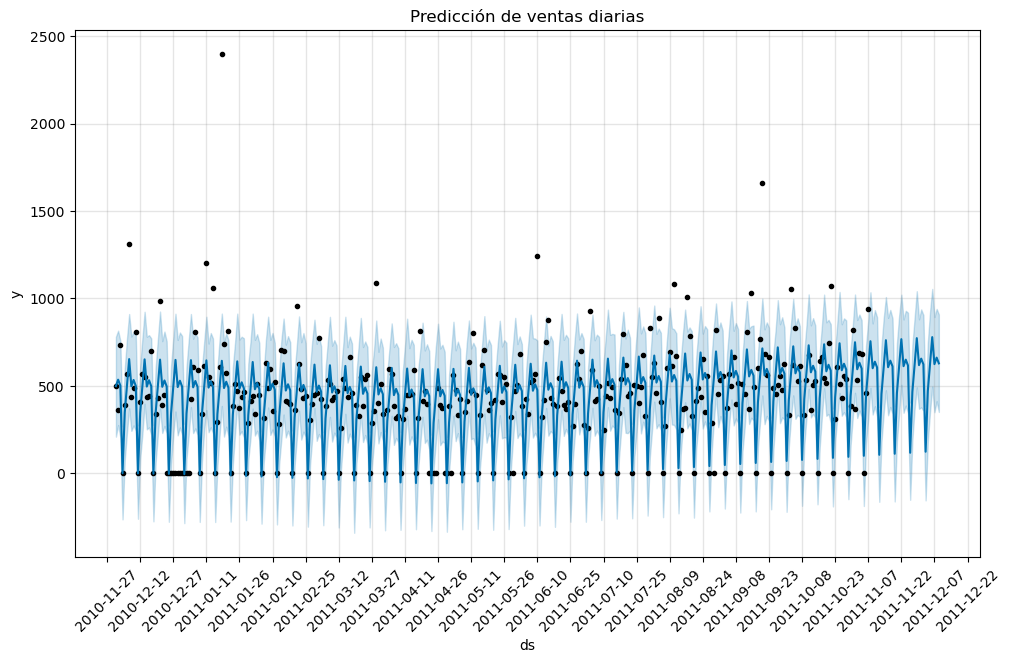

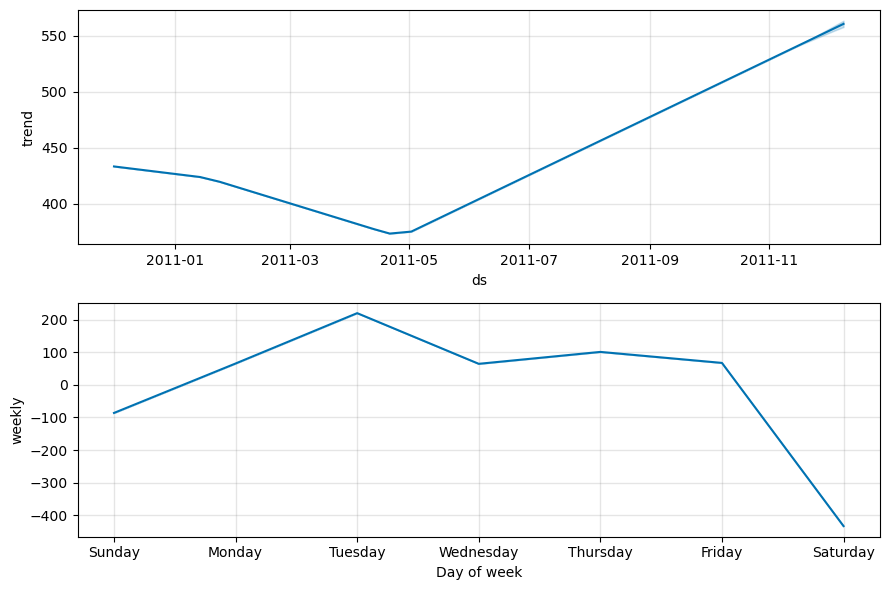

In [82]:
# Gráfico de predicción
fig = model.plot(forecast)
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(31)) 

plt.title('Predicción de ventas diarias')
plt.show()


# Componentes del modelo
fig2 = model.plot_components(forecast)
plt.show()

In [84]:
# calculamos mae
dfPredicReal['InvoiceDate'] = pd.to_datetime(dfPredicReal['InvoiceDate'])
yReal=dfPredicReal.groupby(dfPredicReal['InvoiceDate'].dt.date)['Total'].sum().reset_index()
#yReal = dfPredicReal.set_index('InvoiceDate').resample('h')['Total'].sum().reset_index()
yReal['InvoiceDate'] = pd.to_datetime(yReal['InvoiceDate'])
#Añadimos fechas que faltan
yReal = yReal.set_index('InvoiceDate').resample('D').mean().fillna(0)
yReal = yReal.reset_index()

print(yReal.info())
print(yReal.head())

# dejamos solo el valor
yRealValues= yReal['Total'].values
print(f"\n Sin fecha:")
print(yRealValues)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  32 non-null     datetime64[ns]
 1   Total        32 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 644.0 bytes
None
  InvoiceDate     Total
0  2011-11-08  57557.03
1  2011-11-09  65879.97
2  2011-11-10  70868.00
3  2011-11-11  55107.87
4  2011-11-12      0.00

 Sin fecha:
[ 57557.03  65879.97  70868.    55107.87      0.    33878.15 114237.4
  60613.8   65672.53  60901.32  51130.39      0.    34509.21  49674.6
  63863.48  79847.    50759.21  50690.4       0.    20279.37  56965.73
  72384.82  60025.57  52068.63  57476.48      0.    24477.47  88620.84
  56558.83  75315.55  82371.55 200900.98]


In [86]:
yPred = forecast['yhat'].tail(32)
yPred = yPred.reset_index(drop=True)
yPred.head()
yPredValues= yPred.values

mae=mean_absolute_error(yRealValues, yPredValues)
print('MAE: %.3f' % mae)

MAE: 56111.642


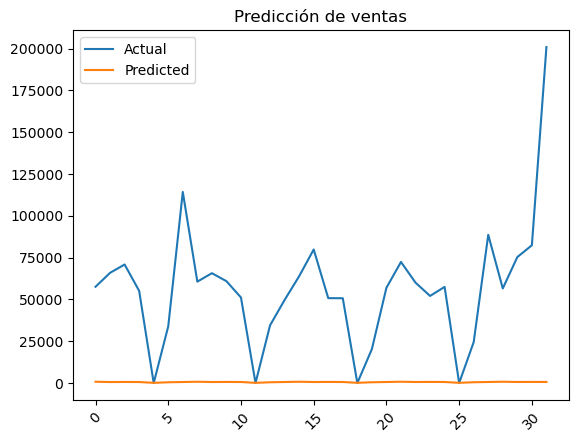

In [88]:
# plot expected vs actual
plt.plot(yRealValues, label='Actual')
plt.plot(yPredValues, label='Predicted')
plt.legend()
plt.xticks(rotation=45)  
plt.title('Predicción de ventas')
plt.show()

In [72]:
# Realizar validación cruzada
df_cv = cross_validation(model, initial='30 days', period='7 days', horizon='7 days');

# Calcular métricas de rendimiento
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mae', 'rmse']])

  0%|          | 0/44 [00:00<?, ?it/s]

17:40:57 - cmdstanpy - INFO - Chain [1] start processing
17:40:57 - cmdstanpy - INFO - Chain [1] done processing
17:40:57 - cmdstanpy - INFO - Chain [1] start processing
17:40:57 - cmdstanpy - INFO - Chain [1] done processing
17:40:57 - cmdstanpy - INFO - Chain [1] start processing
17:40:57 - cmdstanpy - INFO - Chain [1] done processing
17:40:57 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing
17:40:58 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing
17:40:58 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing
17:40:58 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing
17:40:58 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1]

  horizon         mae        rmse
0  1 days  257.389922  366.736064
1  2 days  127.407600  188.387396
2  3 days  162.829109  239.270557
3  4 days  159.809052  246.025068
4  5 days   76.993208  122.602009
5  6 days  128.000088  176.516790
6  7 days  206.002971  272.612349
